In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from naiveBayes import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import naiveBayesv1 as v1

In [2]:
class LinearSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm(range(self.n_iters), desc='训练SVM'):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.b)

    def decision_function(self, X):
        return np.dot(X, self.w) - self.b

In [3]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [4]:
def tsvm_nb_algorithm(X, y):
    # 初始化距离矩阵
    n_samples = len(X)
    distance_matrix = np.full((n_samples, n_samples), np.inf)

    for i in tqdm(range(n_samples), desc='计算距离矩阵'):
        for j in range(n_samples):
            if i != j:
                distance_matrix[i, j] = euclidean_distance(X[i], X[j])

    # 初始化每个点的最近邻和最短距离
    nearest_neighbors = np.zeros(n_samples, dtype=int)
    min_distances = np.full(n_samples, np.inf)

    for i in tqdm(range(n_samples), desc='选择最近邻'):
        for j in range(n_samples):
            if distance_matrix[i, j] < min_distances[i]:
                min_distances[i] = distance_matrix[i, j]
                nearest_neighbors[i] = j

    # 初始化标志矩阵
    flags = np.ones(n_samples)

    for i in tqdm(range(n_samples), desc='计算标志矩阵'):
        neighbor_idx = nearest_neighbors[i]
        if y[i] != y[neighbor_idx]:
            flags[i] = -1
        else:
            flags[i] = 1

    # 修剪样本集
    for i in tqdm(range(n_samples), desc='修剪样本集'):
        neighbor_idx = nearest_neighbors[i]
        if flags[i] == -1:
            # 选择删除点，优先删除距离较远的点
            if min_distances[i] < min_distances[neighbor_idx]:
                X = np.delete(X, i, axis=0)
                y = np.delete(y, i, axis=0)
            else:
                X = np.delete(X, neighbor_idx, axis=0)
                y = np.delete(y, neighbor_idx, axis=0)

    # 再次用NB算法训练
    nb = NaiveBayes()
    nb.fit(X, y)

    return nb

In [5]:
# 加载数据集
docs, label = loadDataSet()
# 创建词汇表
vocabList = createVocabList(docs)

# 构建词向量矩阵
tfidf = TFIDF(docs, vocabList)
trainMat = tfidf.calc_tfidf()

trainMat = np.array(trainMat)
label = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(trainMat, label, test_size=0.2, random_state=1)

# 初始训练
nb_initial = NaiveBayes()
nb_initial.fit(X_train, y_train)
initial_predictions = nb_initial.predict(X_train)

# 构建最优分类超平面
svm = LinearSVM()
svm.fit(X_train, initial_predictions)

distances = svm.decision_function(X_train)
threshold = 0.2
selected_samples = np.abs(distances) > threshold

X_optimized = X_train[selected_samples]
y_optimized = y_train[selected_samples]

nb = tsvm_nb_algorithm(X_optimized, y_optimized)
y_pred = nb.predict(X_test)
y_probs = nb.predict_proba(X_test)[:, 1]  # 选择概率中的正类概率

100%|██████████| 5574/5574 [00:00<00:00, 5835.92it/s]


In [ ]:
# ——————————————————————————————————————————————————————————————————————
# SVM
docs, label = v1.loadDataSet()

vocabList = v1.createVocabList(docs)

trainMat = []
for postinDoc in tqdm(docs):
    trainMat.append(setOfWords2Vec(vocabList, postinDoc))

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(trainMat, label, test_size=0.2, random_state=1)

In [8]:
# 训练SVM模型
svm = SVC(kernel='linear',probability=True)
svm.fit(X_train_o, y_train_o)

svm_pred = svm.predict(X_test_o)
svm_probs = svm.predict_proba(X_test_o)[:, 1] 

In [10]:
# 朴素贝叶斯
nbmodel = MultinomialNB()
nbmodel.fit(X_train_o, y_train_o)

nb_pred = nbmodel.predict(X_test_o)
nb_probs = nbmodel.predict_proba(X_test_o)[:, 1] 

In [11]:
# 计算每个模型的假阳性率、真阳性率和AUC
fpr1, tpr1, _ = roc_curve(y_test, y_probs)
roc_auc1 = roc_auc_score(y_test, y_probs)

fpr2, tpr2, _ = roc_curve(y_test_o, svm_probs)
roc_auc2 = roc_auc_score(y_test_o, svm_probs)

fpr3, tpr3, _ = roc_curve(y_test_o, nb_probs)
roc_auc3 = roc_auc_score(y_test_o, nb_probs)

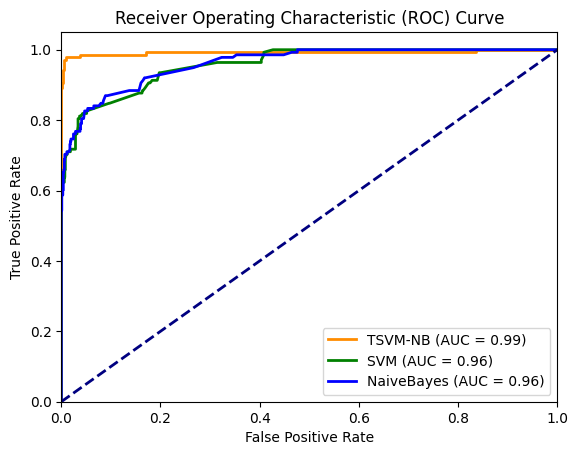

In [12]:
# 绘制ROC曲线
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='TSVM-NB (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', lw=2, label='SVM (AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='blue', lw=2, label='NaiveBayes (AUC = %0.2f)' % roc_auc3)

# 绘制对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设置图形的范围、标签和标题
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# 显示图形
plt.show()

In [13]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred)
mcc_svm=matthews_corrcoef(y_test_o,svm_pred)
mcc_nb=matthews_corrcoef(y_test_o,nb_pred)
print(mcc)
print(mcc_svm)
print(mcc_nb)

0.9440083638646254
0.7739880609854588
0.7622919801490375
